# Project 1: Exploratory Data Analysis of Movies
Amelia Dahm & Khyatee Desai

## Inspecting all the files

1. bom.movie_gross.csv.gz
2. imdb.title.ratings.csv.gz
3. imdb.name.basics.csv.gz
4. rt.movie_info.tsv.gz
5. imdb.title.akas.csv.gz
6. rt.reviews.tsv.gz
7. imdb.title.basics.csv.gz
8. tmdb.movies.csv.gz
9. imdb.title.crew.csv.gz
10. tn.movie_budgets.csv.gz
11. imdb.title.principals.csv.gz

In [2]:
import pandas as pd
import re
import matplotlib as plt
import seaborn as sns
import requests
from bs4 import BeautifulSoup
%matplotlib inline

## movie gross - Table 1

In [3]:
movie_gross_raw = pd.read_csv('./zippedData/bom.movie_gross.csv.gz')
movie_gross_raw.head(1)

,title,studio,domestic_gross,foreign_gross,year
0,Toy Story 3,BV,415000000.0,652000000,2010


## IMDB ratings - Table 2

In [4]:
imdb_raw = pd.read_csv('./zippedData/imdb.title.ratings.csv.gz')
imdb_raw.head(1)

,tconst,averagerating,numvotes
0,tt10356526,8.3,31


## name basics - Table 3

In [5]:
name_basics_raw = pd.read_csv('./zippedData/imdb.name.basics.csv.gz')
name_basics_raw.head(1)

,nconst,primary_name,birth_year,death_year,primary_profession,known_for_titles
0,nm0061671,Mary Ellen Bauder,NaN,NaN,"miscellaneous,production_manager,producer","tt0837562,tt2398241,tt0844471,tt0118553"


## movie info - Table 4

In [6]:
movie_info_raw = pd.read_csv('./zippedData/rt.movie_info.tsv.gz',sep='\t')
movie_info_raw.head(1)

,id,synopsis,rating,genre,director,writer,theater_date,dvd_date,currency,box_office,runtime,studio
0,1,"This gritty, fast-paced, and innovative police...",R,Action and Adventure|Classics|Drama,William Friedkin,Ernest Tidyman,"Oct 9, 1971","Sep 25, 2001",NaN,NaN,104 minutes,NaN


## movie titles - Table 5

In [7]:
titles_raw = pd.read_csv('./zippedData/imdb.title.akas.csv.gz')
titles_raw.head(1)

,title_id,ordering,title,region,language,types,attributes,is_original_title
0,tt0369610,10,Джурасик свят,BG,bg,NaN,NaN,0.0


## RT reviews - Table 6

In [8]:
rt_raw = pd.read_csv('./zippedData/rt.reviews.tsv.gz',sep='\t', encoding = "ISO-8859-1")
rt_raw.head(1)

,id,review,rating,fresh,critic,top_critic,publisher,date
0,3,A distinctly gallows take on contemporary fina...,3/5,fresh,PJ Nabarro,0,Patrick Nabarro,"November 10, 2018"


## Genres/Runtime - Table 7

In [9]:
genre_raw = pd.read_csv('./zippedData/imdb.title.basics.csv.gz')
genre_raw.head(1)

,tconst,primary_title,original_title,start_year,runtime_minutes,genres
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama"


## TMDB Ratings - Table 8

In [10]:
tmdb_raw = pd.read_csv('./zippedData/tmdb.movies.csv.gz')
tmdb_raw.head(1)

,Unnamed: 0,genre_ids,id,original_language,original_title,popularity,release_date,title,vote_average,vote_count
0,0,"[12, 14, 10751]",12444,en,Harry Potter and the Deathly Hallows: Part 1,33.533,2010-11-19,Harry Potter and the Deathly Hallows: Part 1,7.7,10788


## Directors/Writers - Table 9

In [11]:
crew_raw = pd.read_csv('./zippedData/imdb.title.crew.csv.gz')
crew_raw.head(1)

,tconst,directors,writers
0,tt0285252,nm0899854,nm0899854


## Budgets - Table 10

In [12]:
budgets_raw = pd.read_csv('./zippedData/tn.movie_budgets.csv.gz')
budgets_raw.head(1)

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"


## Actors & Characters - Table 11

In [13]:
characters_raw = pd.read_csv('./zippedData/imdb.title.principals.csv.gz')
characters_raw.head(1)

,tconst,ordering,nconst,category,job,characters
0,tt0111414,1,nm0246005,actor,NaN,"[""The Man""]"


## Raw Oscar Data - Table 12

In [14]:
oscars_raw = pd.read_csv('./zippedData/oscars.zip', encoding = "ISO-8859-1")
oscars_raw.head(1)

,year_film,year_ceremony,ceremony,category,name,film,winner
0,1927,1928,1,ACTOR,Richard Barthelmess,The Noose,False


# Question 1: Which Movies Get Oscar Nominations?
### Task: determine the commonalities among Academy award-nominated movies<br>

### External Datasets:
https://www.kaggle.com/unanimad/the-oscar-award
### Data of Interest:
- genre
- budget
- gross revenue
- online ratings
- oscar nominations

# Method:

## 1. Get the count of Oscar Nominations per movie

In [19]:

# subset the relevant data from Oscars df. Rename columns, drop rows with no movie title
oscars = oscars_raw.loc[:,['film','name', 'category']]
oscars.rename(columns={'film': 'title', 'name': 'person'}, inplace=True)
oscars.drop(oscars[oscars['title'].isnull()].index, inplace=True)


# create column for total number of oscar nominations per movie
counts = oscars['title'].value_counts()
d = counts.to_dict()
oscars['oscar_noms'] = oscars['title'].map(d)
oscars.head(3)

,title,person,category,oscar_noms
0,The Noose,Richard Barthelmess,ACTOR,1
1,The Last Command,Emil Jannings,ACTOR,2
2,A Ship Comes In,Louise Dresser,ACTRESS,1


## 2. Unstack the Genre values
genres were originally formatted as a comma-delimited string (ie 'Action, Crime, Drama'.) We reformatted this to give each genre its own row in the table.

In [20]:
# Unstacking Genre column to create individual rows (takes a while to run cell)
genre_ugly = genre_raw
genre_ugly['genres'] = genre_ugly['genres'].str.split(',', 3)
genre_unstack = genre_ugly.set_index('primary_title').genres.apply(pd.Series).stack().reset_index(level=-1, drop=True).astype(str).reset_index()
genre_unstack.columns = ['primary_title', 'genres']
genre_unstack

,primary_title,genres
0,Sunghursh,Action
1,Sunghursh,Crime
2,Sunghursh,Drama
3,One Day Before the Rainy Season,Biography
4,One Day Before the Rainy Season,Drama
...,...,...
229545,The Secret of China,War
229546,Kuambil Lagi Hatiku,Drama
229547,Rodolpho Teóphilo - O Legado de um Pioneiro,Documentary
229548,Dankyavar Danka,Comedy


## 3. Merge Oscars table with Genre table

In [21]:
#  using 'original_title' to retain more rows
oscar_genre = oscars.merge(genre_unstack, how = 'left', left_on='title', right_on='primary_title').drop('primary_title', axis=1)
oscar_genre

,title,person,category,oscar_noms,genres
0,The Noose,Richard Barthelmess,ACTOR,1,Documentary
1,The Last Command,Emil Jannings,ACTOR,2,NaN
2,A Ship Comes In,Louise Dresser,ACTRESS,1,NaN
3,7th Heaven,Janet Gaynor,ACTRESS,5,NaN
4,Sadie Thompson,Gloria Swanson,ACTRESS,1,NaN
...,...,...,...,...,...
15750,Parasite,"Screenplay by Bong Joon Ho, Han Jin Won; Story...",WRITING (Original Screenplay),6,Action
15751,Parasite,"Screenplay by Bong Joon Ho, Han Jin Won; Story...",WRITING (Original Screenplay),6,Horror
15752,Parasite,"Screenplay by Bong Joon Ho, Han Jin Won; Story...",WRITING (Original Screenplay),6,Sci-Fi
15753,Parasite,"Screenplay by Bong Joon Ho, Han Jin Won; Story...",WRITING (Original Screenplay),6,Drama


## 4. Prep Gross Revenue table

In [74]:
# subset relevant data, change strings to floats
movie_gross = movie_gross_raw.loc[:, ['title', 'domestic_gross', 'foreign_gross']]
movie_gross['foreign_gross'] = movie_gross['foreign_gross'].str.replace(',','').astype(float)
movie_gross['total_gross'] = movie_gross.domestic_gross + movie_gross.foreign_gross
movie_gross

,title,domestic_gross,foreign_gross,total_gross
0,Toy Story 3,415000000.0,652000000.0,1.067000e+09
1,Alice in Wonderland (2010),334200000.0,691300000.0,1.025500e+09
2,Harry Potter and the Deathly Hallows Part 1,296000000.0,664300000.0,9.603000e+08
3,Inception,292600000.0,535700000.0,8.283000e+08
4,Shrek Forever After,238700000.0,513900000.0,7.526000e+08
...,...,...,...,...
3382,The Quake,6200.0,NaN,NaN
3383,Edward II (2018 re-release),4800.0,NaN,NaN
3384,El Pacto,2500.0,NaN,NaN
3385,The Swan,2400.0,NaN,NaN


 ## 5. Prep Budgets table

In [75]:
# subset relevant data, change strings to floats
budgets = budgets_raw.loc[:,['movie', 'production_budget', 'domestic_gross', 'worldwide_gross']]
budgets.rename(columns={'movie': 'title', 'worldwide_gross':'total_gross'}, inplace=True)
budgets['production_budget'] = budgets['production_budget'].str.replace('$','')
budgets['production_budget'] = budgets['production_budget'].str.replace(',','').astype(float)
budgets['domestic_gross'] = budgets['domestic_gross'].str.replace('$','')
budgets['domestic_gross'] = budgets['domestic_gross'].str.replace(',','').astype(float)
budgets['total_gross'] = budgets['total_gross'].str.replace('$','')
budgets['total_gross'] = budgets['total_gross'].str.replace(',','').astype(float)
budgets

,title,production_budget,domestic_gross,total_gross
0,Avatar,425000000.0,760507625.0,2.776345e+09
1,Pirates of the Caribbean: On Stranger Tides,410600000.0,241063875.0,1.045664e+09
2,Dark Phoenix,350000000.0,42762350.0,1.497624e+08
3,Avengers: Age of Ultron,330600000.0,459005868.0,1.403014e+09
4,Star Wars Ep. VIII: The Last Jedi,317000000.0,620181382.0,1.316722e+09
...,...,...,...,...
5777,Red 11,7000.0,0.0,0.000000e+00
5778,Following,6000.0,48482.0,2.404950e+05
5779,Return to the Land of Wonders,5000.0,1338.0,1.338000e+03
5780,A Plague So Pleasant,1400.0,0.0,0.000000e+00


## 6. Concatenate Gross Revenue table with Budgets table

In [76]:
# concat gross and budget tables, create columns for total_gross and Return on Investment, drop duplicate rows
budget_concat = pd.concat([movie_gross, budgets])
budget_concat['roi'] = (((budget_concat.total_gross - budget_concat.production_budget)/budget_concat.production_budget)* 100).round(2)
budget_concat.drop_duplicates(subset=['title'],keep='last', inplace=True)
budget_concat

/Users/Khyatee/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


,domestic_gross,foreign_gross,production_budget,title,total_gross,roi
1,334200000.0,691300000.0,NaN,Alice in Wonderland (2010),1.025500e+09,NaN
2,296000000.0,664300000.0,NaN,Harry Potter and the Deathly Hallows Part 1,9.603000e+08,NaN
10,163200000.0,330000000.0,NaN,Clash of the Titans (2010),4.932000e+08,NaN
12,135500000.0,275400000.0,NaN,The King's Speech,4.109000e+08,NaN
13,172100000.0,228000000.0,NaN,Tron Legacy,4.001000e+08,NaN
...,...,...,...,...,...,...
5777,0.0,NaN,7000.0,Red 11,0.000000e+00,-100.00
5778,48482.0,NaN,6000.0,Following,2.404950e+05,3908.25
5779,1338.0,NaN,5000.0,Return to the Land of Wonders,1.338000e+03,-73.24
5780,0.0,NaN,1400.0,A Plague So Pleasant,0.000000e+00,-100.00


# 7. Final Oscar Nominations vs Genre vs Budget DataFrame

In [77]:
# subset the oscars table, drop duplicate listings
oscar_df = oscar_genre.loc[:,['title', "oscar_noms", 'genres']]
oscar_df.drop_duplicates(inplace=True)
oscar_df.sort_values('oscar_noms',ascending=False).head(15)

# join genre/oscar table with budgets.....
oscar_df = oscar_df.merge(budget_concat[['title','production_budget', "total_gross", 'roi']], on='title', how='left').set_index('title')
oscar_df.sort_values('oscar_noms', ascending=False).head(5)

,oscar_noms,genres,production_budget,total_gross,roi
title,,,,,
A Star Is Born,25,Romance,NaN,NaN,NaN
A Star Is Born,25,Drama,NaN,NaN,NaN
A Star Is Born,25,Music,NaN,NaN,NaN
Titanic,16,Family,200000000.0,2.208208e+09,1004.1
Titanic,16,Adventure,200000000.0,2.208208e+09,1004.1


## 8. Plotting Oscar Nominations vs Production Budget
## Khyatee TO DO: 
- remove outliers based on boxplot quartiles
- redraw charts
- draw conclusions

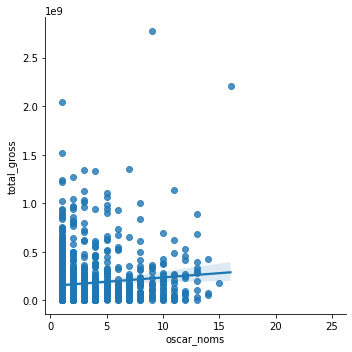

In [80]:
x ='oscar_noms'
y = 'total_gross'
# drop duplicates that exist because of genre unstacking (genre not relevant for this chart)
noms_vs_budget = oscar_df.loc[:,[x, y]].drop_duplicates()
sns.lmplot(x,y, data = noms_vs_budget)

## 9. Plotting Oscar Nominations per Genre

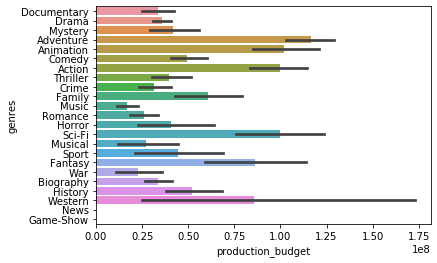

In [81]:
sns.barplot('production_budget','genres' , data = oscar_df)

# Question 2: How does Trailer Popularity impact Movie Success?
### Task: Compare movie trailer view counts to movie ratings and revenue

### Data of Interest:
- trailer views
- gross revenue
- online ratings

### Datasets:
https://grouplens.org/datasets/movielens/20m-youtube/

## merge youtube dataset with budgets table

In [92]:
# slice year out of title string, merge with budgets table
trailers_raw = pd.read_csv('./zippedData/movie_trailers.zip')
trailers_raw['title'] = trailers_raw['title'].str[:-7]
trailers = trailers_raw.merge(budget_concat, on='title').sort_values('total_gross', ascending=False) #### remove this later
ids = list(trailers["youtubeId"].values[:])
trailers

,youtubeId,movieId,title,domestic_gross,foreign_gross,production_budget,total_gross,roi
2745,5MB3Ea6L-gw,72998,Avatar,760507625.0,NaN,425000000.0,2.776345e+09,553.26
458,dQ7MAigAhas,3404,Titanic,659363944.0,NaN,200000000.0,2.208208e+09,1004.10
457,2e-eXJ6HgkQ,1721,Titanic,659363944.0,NaN,200000000.0,2.208208e+09,1004.10
459,yxIVO7P0iig,118916,Titanic,659363944.0,NaN,200000000.0,2.208208e+09,1004.10
2798,tck0UR2ppjg,82452,Frozen,400738009.0,NaN,150000000.0,1.272470e+09,748.31
...,...,...,...,...,...,...,...,...
4012,myjar5KoqZA,129820,Spare Parts,3600000.0,NaN,NaN,NaN,NaN
4017,utmvmr7cgcg,130052,Clown,55000.0,NaN,NaN,NaN,NaN
4020,tRn3gr8Pt_o,130382,Mr. Pip,1700.0,NaN,NaN,NaN,NaN
4028,6uaWekLrilY,131023,That Sugar Film,3500.0,NaN,NaN,NaN,NaN


## Create function to feed in youtube id's of trailers and retrieve view counts

In [83]:

def getViews(youtubeIDs):
    views = []
    for i in youtubeIDs:
        try:
            url = "https://www.youtube.com/watch?v={}".format(i)
            html_page = requests.get(url) 
            soup = BeautifulSoup(html_page.text, 'html.parser')
            script = soup.find_all('script')[32]
            value = re.findall('ewCount":{"simpleText":"([\d,]+) views', str(soup))
            views.append(float(value[0].replace(',','')))
        except:
            views.append(0)
    return views


## Scrape all YouTube Trailers and save as CSV (Warning: takes ~1hr to run)
### Leave this commented out

In [96]:
# trailers['trailer_views'] = getViews(ids)
# trailers.to_csv('zippedData/trailerViews.csv')

# Final Trailer Views vs ROI DataFrame

In [101]:
# sort by trailer views and drop duplicates to keep only trailer with highest views
trailer_df = pd.read_csv('zippedData/trailerViews.csv')
trailer_df = trailer_df.loc[:,['title','youtubeId','production_budget', 'total_gross', 'roi', 'trailer_views']].sort_values('trailer_views', ascending=False)
trailer_df = trailer_df.drop_duplicates(subset= ['title'], keep='first').set_index('title')
trailer_df

,youtubeId,production_budget,total_gross,roi,trailer_views
title,,,,,
Unfaithful,j-V12tL78Mc,50000000.0,1.191145e+08,138.23,117290789.0
Ilo Ilo,ISovsVvX8Bg,NaN,1.156800e+06,NaN,67247941.0
Transformers: Dark of the Moon,3H8bnKdf654,195000000.0,1.123791e+09,476.30,53112332.0
The Fault in Our Stars,9ItBvH5J6ss,12000000.0,3.071668e+08,2459.72,44956623.0
Eden,pdbI0Fn4COQ,2300000.0,0.000000e+00,-100.00,43188495.0
...,...,...,...,...,...
Harry Brown,I2S3SraFmI0,7300000.0,1.202361e+07,64.71,0.0
Elles,YIWiNzszcAo,NaN,9.120000e+05,NaN,0.0
Miral,4t8E6_S9f4k,NaN,9.000000e+05,NaN,0.0


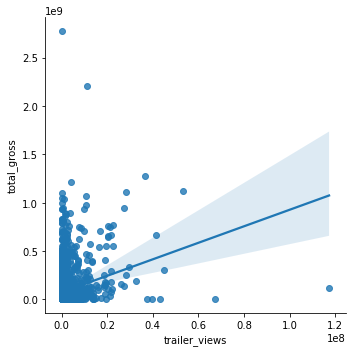

In [102]:
sns.lmplot('trailer_views', 'total_gross', data = trailer_df)

# Question 3: Do Music Scores Contribute to Movie Success?
### Task: Look at how music score ratings compare to movie ratings and ROI
### Data of Interest:
- composers
- music score rating
- TMDB rating
- IMDB rating
- ROI

### Datasets: 
- https://www.soundtrack.net/content/reviews/
- http://www.movie-wave.net/reviews-by-composer/


## Scrape music reviews page

In [104]:
page = requests.get("http://www.movie-wave.net/reviews-by-title/")
soup = BeautifulSoup(page.content, 'html.parser')
content =soup.find('div', class_="page-content")
p_list = content.findAll('p')

In [108]:
to_df =[]
for p in p_list:
    for a in p.findAll('a'):
        try:
           to_df.append([a.text, a.nextSibling, a.nextSibling.nextSibling.text])
        except:
            pass

## Create DataFrame with music score ratings info

In [121]:
music_df = pd.DataFrame(to_df, columns=['title', 'composer', 'stars'])
music_df['composer'] = music_df['composer'].str[:-7]

In [123]:
stars = list(music_df.stars)
mapper = {'*****':5, '**** 1/2':4.5,'****':4,'*** 1/2':3.5,'***':3,'** 1/2':2.5,'**':2,'* 1/2':1.5,'*':1}
ratings = list(map(mapper.get, stars))
music_df['music_rating'] = ratings
music_df = music_df.drop('stars',axis=1)
music_df

,title,composer,music_rating
0,10 Cloverfield Lane,Bear McCreary,4.0
1,100 Rifles,Jerry Goldsmith,4.0
2,101 Dalmatians,Michael Kamen,4.5
3,102 Dalmatians,David Newman,4.0
4,"10,000BC",Harald Kloser and Thomas Wander,2.0
...,...,...,...
2294,Zathura,John Debney,4.0
2295,Zero Dark Thirty,Alexandre Desplat,4.0
2296,Zoolander 2,Theodore Shapiro,3.5
2297,Zootopia,Michael Giacchino,2.0


## Merge TMDB Ratings with Budget/ROI table

In [124]:
# Rename columns to specify TMDB, and subset data to only get columns of interest
tmdb = tmdb_raw.merge(budget_concat[['title', 'total_gross','production_budget', 'roi']], on='title', how='left')
tmdb.rename(columns ={'popularity':'tmdb_popularity', 'vote_average': 'tmdb_rating', 'vote_count': 'tmdb_votes'}, inplace=True)
tmdb = tmdb.loc[:,['title', 'tmdb_rating', 'tmdb_votes', 'tmdb_popularity', 'total_gross', 'production_budget', 'roi']]
tmdb.head()

,title,tmdb_rating,tmdb_votes,tmdb_popularity,total_gross,production_budget,roi
0,Harry Potter and the Deathly Hallows: Part 1,7.7,10788,33.533,NaN,NaN,NaN
1,How to Train Your Dragon,7.7,7610,28.734,494870992.0,165000000.0,199.92
2,Iron Man 2,6.8,12368,28.515,621156389.0,170000000.0,265.39
3,Toy Story,7.9,10174,28.005,364545516.0,30000000.0,1115.15
4,Inception,8.3,22186,27.920,835524642.0,160000000.0,422.20


## merge in IMDB ratings with above TMDB table

In [125]:
# To retain as much info as possible, joined imdb_ratings with title table rather than title_basics
imdb = imdb_raw.merge(titles_raw,left_on ='tconst', right_on ='title_id')
imdb.rename(columns ={'averagerating':'imdb_rating', 'numvotes': 'imdb_votes'}, inplace=True)
imdb = imdb[['title', 'imdb_rating', 'imdb_votes' ]]
ratings = imdb.merge(tmdb, on='title', how='left')
ratings

,title,imdb_rating,imdb_votes,tmdb_rating,tmdb_votes,tmdb_popularity,total_gross,production_budget,roi
0,Just Inès,6.4,20,NaN,NaN,NaN,NaN,NaN,NaN
1,Samo Ines,6.4,20,NaN,NaN,NaN,NaN,NaN,NaN
2,Just Inès,6.4,20,NaN,NaN,NaN,NaN,NaN,NaN
3,The Legend of Hercules,4.2,50352,4.5,805.0,13.754,58953319.0,70000000.0,-15.78
4,Hércules - A Lenda Começa,4.2,50352,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
269218,Coming Out,6.3,21,NaN,NaN,NaN,NaN,NaN,NaN
269219,Code Geass: Lelouch of the Rebellion Episode III,7.5,24,NaN,NaN,NaN,NaN,NaN,NaN
269220,Code Geass: Lelouch of the Rebellion Episode III,7.5,24,NaN,NaN,NaN,NaN,NaN,NaN
269221,Code Geass: Lelouch of the Rebellion - Glorifi...,7.5,24,NaN,NaN,NaN,NaN,NaN,NaN


# Final Music X IMDB X TMDB X Revenue Table

In [126]:
music_df.merge(ratings, on='title', how='right')

,title,composer,music_rating,imdb_rating,imdb_votes,tmdb_rating,tmdb_votes,tmdb_popularity,total_gross,production_budget,roi
0,10 Cloverfield Lane,Bear McCreary,4.0,7.2,260383,6.9,4629.0,17.892,108286422.0,5000000.0,2065.73
1,10 Cloverfield Lane,Bear McCreary,4.0,7.2,260383,6.9,4629.0,17.892,108286422.0,5000000.0,2065.73
2,10 Cloverfield Lane,Bear McCreary,4.0,7.2,260383,6.9,4629.0,17.892,108286422.0,5000000.0,2065.73
3,10 Cloverfield Lane,Bear McCreary,4.0,7.2,260383,6.9,4629.0,17.892,108286422.0,5000000.0,2065.73
4,10 Cloverfield Lane,Bear McCreary,4.0,7.2,260383,6.9,4629.0,17.892,108286422.0,5000000.0,2065.73
...,...,...,...,...,...,...,...,...,...,...,...
269447,Да се разкриеш,NaN,NaN,6.3,21,NaN,NaN,NaN,NaN,NaN,NaN
269448,Code Geass: Lelouch of the Rebellion Episode III,NaN,NaN,7.5,24,NaN,NaN,NaN,NaN,NaN,NaN
269449,Code Geass: Lelouch of the Rebellion Episode III,NaN,NaN,7.5,24,NaN,NaN,NaN,NaN,NaN,NaN
269450,Code Geass: Lelouch of the Rebellion - Glorifi...,NaN,NaN,7.5,24,NaN,NaN,NaN,NaN,NaN,NaN
